In [1]:
import torch
from diff3f import get_features_per_vertex
from time import time
from utils import convert_mesh_container_to_torch_mesh, cosine_similarity, double_plot, get_colors, generate_colors, double_plot_mesh_and_pointcloud
from dataloaders.mesh_container import MeshContainer
from diffusion import init_pipe
from dino import init_dino
from functional_map import compute_surface_map

ImportError: cannot import name 'cached_download' from 'huggingface_hub' (/home/aaryap/miniconda3/envs/diff3f/lib/python3.10/site-packages/huggingface_hub/__init__.py)

In [6]:
device = torch.device('cuda:0')
torch.cuda.set_device(device)
num_views = 100
H = 512
W = 512
num_images_per_prompt = 1
tolerance = 0.004
random_seed = 42
use_normal_map = True

In [7]:
from pytorch3d.structures import Pointclouds

def convert_pointcloud_to_torch_pointcloud(pc, device):
    # pc is a MeshContainer, we need to access its vertices from the .vert attribute
    points = torch.tensor(pc.vert, dtype=torch.float32)
    colors = torch.ones_like(points) * 0.8
    pointcloud = Pointclouds(points=[points.to(device)], features=[colors.to(device)])
    return pointcloud

In [8]:
def compute_features(device, pipe, dino_model, m, prompt, ply=False):
    if not ply:
        mesh = convert_mesh_container_to_torch_mesh(m, device=device, is_tosca=False)
        mesh_vertices = mesh.verts_list()[0]
    else : 
        mesh = convert_pointcloud_to_torch_pointcloud(m, device=device)
        mesh_vertices = mesh.points_list()[0]
    features = get_features_per_vertex(
        device=device,
        pipe=pipe, 
        dino_model=dino_model,
        mesh=mesh,
        prompt=prompt,
        mesh_vertices=mesh_vertices,
        num_views=num_views,
        H=H,
        W=W,
        tolerance=tolerance,
        num_images_per_prompt=num_images_per_prompt,
        use_normal_map=use_normal_map,
        ply=ply
    )
    return features.cpu()

In [9]:
pipe = init_pipe(device)
dino_model = init_dino(device)

/home/aaryap/miniconda3/envs/diff3f/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/aaryap/miniconda3/envs/diff3f/lib/python3.10/site-packages/diffusers/configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
Using cache found in /home/aaryap/.cache/torch/hub/facebookresearch_dinov2_main
/home/aaryap/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/aaryap/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: Use

In [10]:
source_file_path = "./mesh_to_ply/0bf77b32a6d14bd98a23020982da2ced_ply_frames/rest_pose.obj"
target_file_path = "./mesh_to_ply/0bf77b32a6d14bd98a23020982da2ced_ply_frames/frame_0000.ply"
source_mesh = MeshContainer().load_from_file(source_file_path)
target_mesh = MeshContainer().load_from_file(target_file_path)

print(convert_mesh_container_to_torch_mesh(source_mesh, device=device, is_tosca=False).verts_list()[0].shape)

torch.Size([2489, 3])


In [11]:
f_source = compute_features(device, pipe, dino_model, source_mesh, "robot") # (N_vertices, 2048)

Rendering complete


/home/aaryap/miniconda3/envs/diff3f/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 100/100 [04:43<00:00,  2.83s/it]

Number of missing features:  38
Copied features from nearest vertices
Time taken in mins:  4.829719058672587


In [12]:
f_target = compute_features(device, pipe, dino_model, target_mesh, "robot",True)


Rendering complete


100%|██████████| 100/100 [07:04<00:00,  4.25s/it]

Number of missing features:  867
Copied features from nearest vertices
Time taken in mins:  7.251418880621592


In [16]:
s = cosine_similarity(f_source.to(device),f_target.to(device))
s = torch.argmax(s, dim=0).cpu().numpy()
cmap_source = get_colors(source_mesh.vert); cmap_target = cmap_source[s]
import numpy as np
print("s shape:", s.shape)
# print("s dtype:", s.dtype)
# print("s min/max:", s.min(), s.max())
# print("First 20 entries of s:", s[:20])
# print("Unique values in s (truncated):", np.unique(s)[:20], " ... total:", len(np.unique(s)))

np.save("s2.npy", s)
print("s saved to s.npy")

s shape: (55005,)
s saved to s.npy


In [14]:
double_plot_mesh_and_pointcloud(source_mesh,target_mesh,cmap_source,cmap_target)  

Found 6 frames


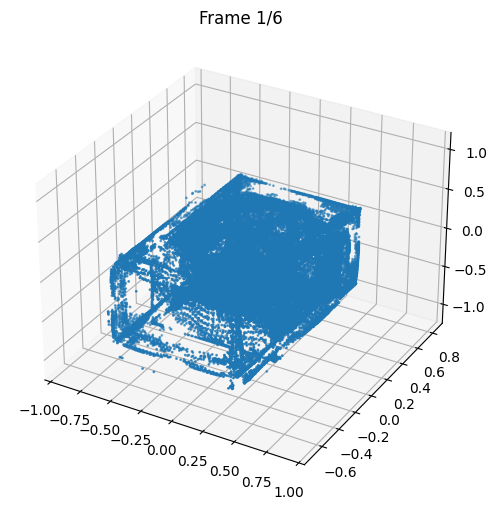

In [2]:
# Visualize ply frames
import os
import glob
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from matplotlib import animation

# --- 1. Configure your folder ---
PLY_FOLDER = "./mesh_to_ply/0bf77b32a6d14bd98a23020982da2ced_ply_frames/output_animated_plys/"
ply_files = sorted(glob.glob(os.path.join(PLY_FOLDER, "*.ply")))

print(f"Found {len(ply_files)} frames")

# --- 2. Load all frames into memory ---
point_clouds = []
for f in ply_files:
    pcd = o3d.io.read_point_cloud(f)
    pts = np.asarray(pcd.points)
    point_clouds.append(pts)

# --- 3. Setup matplotlib figure ---
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection="3d")

# fix axis limits (so the view doesn’t jump frame to frame)
all_points = np.vstack(point_clouds)
mins = all_points.min(axis=0)
maxs = all_points.max(axis=0)
ax.set_xlim(mins[0], maxs[0])
ax.set_ylim(mins[1], maxs[1])
ax.set_zlim(mins[2], maxs[2])

scat = ax.scatter([], [], [], s=1)

# --- 4. Update function for animation ---
def update(frame_idx):
    pts = point_clouds[frame_idx]
    scat._offsets3d = (pts[:,0], pts[:,1], pts[:,2])
    ax.set_title(f"Frame {frame_idx+1}/{len(point_clouds)}")
    return scat,

# --- 5. Animate ---
ani = animation.FuncAnimation(fig, update, frames=len(point_clouds),
                              interval=200, blit=False)

# show animation inline
HTML(ani.to_jshtml())


# Apply functional map on features

In [ ]:
# source_file_path = "meshes/cat.off"
# target_file_path = "meshes/lion.off"
source_mesh = MeshContainer().load_from_file(source_file_path)
target_mesh = MeshContainer().load_from_file(target_file_path)
f_source = compute_features(device, pipe, dino_model, source_mesh, "robot")
f_target = compute_features(device, pipe, dino_model, target_mesh, "robot")

Rendering complete


100%|██████████| 100/100 [10:16<00:00,  6.17s/it]


Number of missing features:  140
Copied features from nearest vertices
Time taken in mins:  10.621053489049276
Rendering complete


100%|██████████| 100/100 [10:14<00:00,  6.14s/it]

Number of missing features:  17
Copied features from nearest vertices
Time taken in mins:  10.467332740624746


In [8]:
s = cosine_similarity(f_source.to(device),f_target.to(device))
s = torch.argmax(s, dim=0).cpu().numpy()
cmap_source = get_colors(source_mesh.vert); cmap_target = cmap_source[s]
double_plot(source_mesh,target_mesh,cmap_source,cmap_target)  

NameError: name 'f_source' is not defined

In [11]:
surface_map = compute_surface_map(source_file_path, target_file_path, f_source.numpy(), f_target.numpy())

KeyError: 'faces'

In [ ]:
cmap_source = get_colors(source_mesh.vert); cmap_target = cmap_source[surface_map.cpu().numpy()]
double_plot(source_mesh,target_mesh,cmap_source,cmap_target)  

# Part segmentation

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

k = 6

kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(f_source)

segments1 = kmeans.predict(f_source)

# Apply centroids on another mesh to segment it in a corresponding manner
segments2 = kmeans.predict(f_target)

In [ ]:
segment_colors = generate_colors(k)
cmap_source = np.array([segment_colors[j] for j in segments1])
cmap_target = np.array([segment_colors[j] for j in segments2])

In [ ]:
double_plot(source_mesh,target_mesh,cmap_source,cmap_target)  

In [ ]:
source_file_path = "meshes/posed_human.off"
target_file_path = "meshes/cat.off"
source_mesh = MeshContainer().load_from_file(source_file_path)
target_mesh = MeshContainer().load_from_file(target_file_path)
f_source = compute_features(device, pipe, dino_model, source_mesh, "naked human")
f_target = compute_features(device, pipe, dino_model, target_mesh, "cat")

Rendering complete


100%|██████████| 100/100 [10:15<00:00,  6.16s/it]


Number of missing features:  3
Copied features from nearest vertices
Time taken in mins:  10.55890489021937
Rendering complete


100%|██████████| 100/100 [10:29<00:00,  6.29s/it]

Number of missing features:  140
Copied features from nearest vertices
Time taken in mins:  10.672471817334493


In [ ]:
k = 6

kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(f_source)

segments1 = kmeans.predict(f_source)

# Apply centroids on another mesh to segment it in a corresponding manner

segments2 = kmeans.predict(f_target)
segment_colors = generate_colors(k)
cmap_source = np.array([segment_colors[j] for j in segments1])
cmap_target = np.array([segment_colors[j] for j in segments2])

In [ ]:
double_plot(source_mesh,target_mesh,cmap_source,cmap_target)  